In [196]:
%pip install mne
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
import datetime
import mne
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

/var/folders/pr/v9q3lhrs5j96v2xlgbgmkx640000gp/T/ipykernel_12034/3081062061.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Clean up the df! 

In [2]:
#read csv!
df = pd.read_csv("eeg_data.csv")

#start with (4677, 35)
print(df.shape)

(4677, 31)


In [3]:
#look at other values to see bad input
for col in df.columns:
    print(df[col].value_counts())

#values that indicate no input or input that can't be processed with that column
bad_values = ["-", " -", " ", "?", "Indeterminate", "indeterminate", "overwritten", "error", "10 out of 25", "0?", "7-->2", "6-->10", "#REF!", "na", "n/a", "m", " na"]

EEG STUDY ID
1184    20
1056    18
1316    17
726     17
149     16
        ..
1211     1
1201     1
1198     1
1194     1
2514     1
Name: count, Length: 1298, dtype: int64
Epigenetics of Delirium Study ID
-      255
322      2
454      1
448      1
449      1
      ... 
238      1
237      1
236      1
235      1
882      1
Name: count, Length: 573, dtype: int64
Date
5/25/2018    18
2/27/2019    14
5/17/2018    14
6/8/2017     14
6/29/2017    13
             ..
4/15/2017     1
4/9/2017      1
4/8/2017      1
4/7/2017      1
3/9/2020      1
Name: count, Length: 1140, dtype: int64
Delirious Updated
#NAME?    4676
Name: count, dtype: int64
Delirious (0=N, 1=Y)
0     2699
1      860
-       67
0?       1
1?       1
?        1
Name: count, dtype: int64
Fukuda Denshi EEG SD
0.14     36
0.11     33
0.13     30
0.17     29
0.19     24
0.12     24
0.18     19
0.15     17
0.16     17
0.09     17
0.1      15
0.08     12
0.2       9
0.07      5
0.21      4
0.03      3
0.25      2
0.22      2
-  

In [4]:
#Go through and replace these bad values with nan
df.replace(bad_values, [None] * len(bad_values), inplace=True)

In [5]:
#drop any rows without a delirium result, not helpful for inference
df = df[(df['Delirious (0=N, 1=Y)'] == '0') | (df['Delirious (0=N, 1=Y)'] == '1')]

In [6]:
#drop a bunch of superfluous values -- anything with not enough data
for col in df.columns:
    ratio_null = df[col].isna().sum()/len(df[col])
    if ratio_null > 0.8:
        print(col)
        df.drop(col, axis=1, inplace=True)

#drop unnecssary column 
df.drop("Delirious Updated", axis=1, inplace=True)
df.drop("Delirious (0=N, 1=Y).1", axis=1, inplace=True)

Epigenetics of Delirium Study ID
Fukuda Denshi EEG SD
Fukuda Denshi EEG Score
EEG SD 250 Hz Script
EEG Ch 1 250 Hz Script
MAX EEG Score during enrolled encoutner
MoCa Max
CDR Score
Max Total DRS Score during enrolled encoutner
Entropy_RE
Entropy_SE
NOTES


In [7]:
#result = data with only columns that have over 80% filled + study id, delirious 
df.head(50)

,EEG STUDY ID,Date,"Delirious (0=N, 1=Y)",EEG Ch 2 (3 to 10 Hz ratio),EEG Ch 1 - EEG Ch 2,Average EEG Ratio,SD,MoCA,DOSS,DRS TOTAL score,CAM-ICU,RASS,Hyper/Hypo,DRS SEVERITY score,DRS max possible severity score,DRS TOTAL score.1,DRS max possible TOTAL score
0,1,1/11/2016,0,None,None,None,NaN,23,None,None,None,None,None,None,None,None,None
1,2,1/25/2016,0,None,None,None,NaN,18,None,None,None,None,None,None,None,None,None
2,3,1/26/2016,0,None,None,None,NaN,17,None,None,None,None,None,None,None,None,None
3,4,2/1/2016,0,None,None,None,NaN,19,None,None,None,None,None,None,None,None,None
4,5,2/3/2016,0,None,None,None,NaN,27,None,None,None,None,None,None,None,None,None
5,6,2/4/2016,0,None,None,None,NaN,14,None,None,None,None,None,None,None,None,None
6,7,2/5/2016,0,None,None,None,NaN,28,None,None,None,None,None,None,None,None,None
7,8,2/8/2016,0,None,None,None,NaN,NaN,None,None,NaN,None,None,None,None,None,None
8,9,2/11/2016,0,None,None,None,NaN,NaN,None,None,NaN,None,None,None,None,None,None
9,10,2/11/2016,0,None,None,None,NaN,NaN,None,None,NaN,None,None,None,None,None,None


In [8]:
#end with (3559, 17)
print(df.shape)

(3559, 17)


In [10]:
df.to_csv("/Users/taylor/Desktop/Grade 12/ATCS/eeg-analysis/cleaned_data.csv", index=False)

In [9]:
df['file'] = None

## Start managing the files

In [10]:
#gets list of all files
def get_list_of_files(filepath):
  entries = os.listdir(filepath)
  files = []
  for item in entries:
    if os.path.isdir(os.path.join(filepath, item)):
      files.extend(get_list_of_files(os.path.join(filepath, item)))
  files.extend([os.path.join(filepath, x) for x in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, item)) and os.path.join(filepath, item)[-4:] == ".edf"])
  return files

#1193 EEG files
files = get_list_of_files("edf_files/")

In [11]:
#extract id, date from filenames
#kinda klunky but... files were named weirdly :( 
def to_datetime(timedate):
  rem_paren = timedate.split('/')[-1]
  filename = rem_paren.split("_")
  EEG_ID = filename[0]
  date = filename[1]
  if date[len(date)-4:len(date)] == '2019' or date[len(date)-4:len(date)] == '2020' or date[len(date)-4:len(date)] == '2018' or date[len(date)-4:len(date)] == '2017' or date[len(date)-4:len(date)] == '2016':
    month = date[len(date)-8:len(date)-6]
    day = date[len(date)-6:len(date)-4]
    year = date[len(date)-4:len(date)]
  else:
    year = date[len(date)-8:len(date)-4]
    month = date[len(date)-4:len(date)-2]
    day = date[len(date)-2:len(date)]
  try:
    return (int(EEG_ID), datetime.datetime(int(year), int(month), int(day)))
  except Exception as e:
    return ()

In [12]:
#extract datetime from filenames, match with id and filename
matched = {}
for val in files:
  try:
    split_up = to_datetime(val)
    if len(split_up) > 0:
      id = split_up[0]
      time = str(split_up[1])
      matched[id] = (time, val)
  except:
    print(" :( ")

print(matched)

 :( 
 :( 
 :( 
{1156: ('2018-04-11 00:00:00', 'edf_files/EDF Files - Old EEG Device/April 2018 EDF files/1156_JG20180411_1530-1535.edf'), 1159: ('2018-04-10 00:00:00', 'edf_files/EDF Files - Old EEG Device/week of 18Apr7 - 18Apr13/1159_DB20180410_1319-1324.edf'), 1163: ('2018-04-10 00:00:00', 'edf_files/EDF Files - Old EEG Device/week of 18Apr7 - 18Apr13/1163_AS20180410_1050-1055.edf'), 1171: ('2018-04-12 00:00:00', 'edf_files/EDF Files - Old EEG Device/week of 18Apr7 - 18Apr13/1171_LT20180412_1040-1045.edf'), 897: ('2017-12-13 00:00:00', 'edf_files/EDF Files - Old EEG Device/week of 17Dec1 - 17Dec14/0897_GJ20171213_0933-0936.edf'), 892: ('2017-12-05 00:00:00', 'edf_files/EDF Files - Old EEG Device/week of 17Dec1 - 17Dec14/0892_RS20171205_0956-0959.edf'), 890: ('2017-12-07 00:00:00', 'edf_files/EDF Files - Old EEG Device/week of 17Dec1 - 17Dec14/0890_CH20171207_0919-0922.edf'), 894: ('2017-12-06 00:00:00', 'edf_files/EDF Files - Old EEG Device/week of 17Dec1 - 17Dec14/0894_LM20171206_1

### Match files with associated data

In [18]:
from datetime import datetime 

#correctly formatting strings bcs different formatting in df & dictionary
def rem_0s(s):
    d_pattern = r'\b(0?)(\d+)/0?(\d+)/(\d{2,4})\b'
    def reformat_date(match):
        day, month, year = match.group(2), match.group(3), match.group(4)
        #add "20" in front of year
        if len(year) == 2:
            year = "20" + year
        return f"{int(day)}/{int(month)}/{year}"
    return re.sub(d_pattern, reformat_date, s)

#keep list of rows missing an eeg or where both date/id don't match
missing_eeg = []
not_matching = []
use_files = []

for idx, row in df.iterrows():
    #convert matched id to int 
    match = re.match(r'\d+', row["EEG STUDY ID"])
    match = int(match.group())
    date = row["Date"]
    try:
        #get date in proper format
        check_date = str(matched[match][0]).split(" ")[0].replace("-", "/")
        date_obj = datetime.strptime(check_date, "%Y/%d/%m")
        formatted = date_obj.strftime("%d/%m/%y")
        formatted = rem_0s(formatted)
        #if id && date match, then the file is correct
        if formatted == date:
            print(date, match, matched[match])
            df.at[idx, 'file'] = matched[match][1]
            use_files.append(matched[match][1])
        else:
            not_matching.append(matched[match])
    except:
        missing_eeg.append(match)

4/10/2016 33 ('2016-04-10 00:00:00', 'edf_files/EDF Files - Old EEG Device/Feb - May 2016 EDF files/0033_04102016_1447-1457.edf')
6/1/2016 128 ('2016-06-01 00:00:00', 'edf_files/EDF Files - Old EEG Device/Jun 2016 EDF files/0128_20160601_1642-1652.edf')
6/7/2016 138 ('2016-06-07 00:00:00', 'edf_files/EDF Files - Old EEG Device/Jun 2016 EDF files/0138_20160607_1726-1736.edf')
6/10/2016 141 ('2016-06-10 00:00:00', 'edf_files/EDF Files - Old EEG Device/Jun 2016 EDF files/0141_20160610_1418-1428.edf')
8/5/2016 208 ('2016-08-05 00:00:00', 'edf_files/EDF Files - Old EEG Device/Aug 2016 EDF files/0208_20160805_0914-0924.edf')
8/5/2016 208 ('2016-08-05 00:00:00', 'edf_files/EDF Files - Old EEG Device/Aug 2016 EDF files/0208_20160805_0914-0924.edf')
8/5/2016 215 ('2016-08-05 00:00:00', 'edf_files/EDF Files - Old EEG Device/Aug 2016 EDF files/0215_20160805_1650-1700.edf')
8/6/2016 217 ('2016-08-06 00:00:00', 'edf_files/EDF Files - Old EEG Device/Aug 2016 EDF files/0217_20160806_1100-1110.edf')
8

In [14]:
#drop anything without an associated file
df = df.dropna(subset=['file'])

In [16]:
df.head(30)

,EEG STUDY ID,Date,"Delirious (0=N, 1=Y)",EEG Ch 2 (3 to 10 Hz ratio),EEG Ch 1 - EEG Ch 2,Average EEG Ratio,SD,MoCA,DOSS,DRS TOTAL score,CAM-ICU,RASS,Hyper/Hypo,DRS SEVERITY score,DRS max possible severity score,DRS TOTAL score.1,DRS max possible TOTAL score,file
61,33,4/10/2016,0,None,None,None,None,NaN,None,None,NaN,None,None,None,None,None,None,edf_files/EDF Files - Old EEG Device/Feb - May...
158,128,6/1/2016,0,1.2,0.05,1.175,0.153309,28,None,None,negative,None,None,None,None,None,None,edf_files/EDF Files - Old EEG Device/Jun 2016 ...
183,138,6/7/2016,0,1.25,0.05,1.275,0.135462,26,None,None,negative,None,None,None,None,None,None,edf_files/EDF Files - Old EEG Device/Jun 2016 ...
205,141,6/10/2016,0,1.41,0,1.41,0.0871871,30,None,None,negative,None,None,None,None,None,None,edf_files/EDF Files - Old EEG Device/Jun 2016 ...
360,208,8/5/2016,0,1.37,0.01,1.365,NaN,NaN,NaN,2,negative,None,None,2,39,2,46,edf_files/EDF Files - Old EEG Device/Aug 2016 ...
361,208,8/5/2016,0,1.33,0.06,1.36,NaN,NaN,NaN,1,negative,None,None,1,39,1,46,edf_files/EDF Files - Old EEG Device/Aug 2016 ...
366,215,8/5/2016,0,None,None,None,0.111503,22,0,4,NaN,None,None,4,39,4,46,edf_files/EDF Files - Old EEG Device/Aug 2016 ...
368,217,8/6/2016,0,1.48,0.04,1.46,NaN,NaN,NaN,13,negative,None,None,8,39,13,46,edf_files/EDF Files - Old EEG Device/Aug 2016 ...
376,218,8/11/2016,0,1.29,0.08,1.25,NaN,NaN,NaN,6,NaN,None,None,5,39,6,46,edf_files/EDF Files - Old EEG Device/Aug 2016 ...
380,222,8/11/2016,1,1.43,0.07,1.465,NaN,NaN,NaN,None,None,None,None,None,None,None,None,edf_files/EDF Files - Old EEG Device/Aug 2016 ...


## Clean EEG data

In [24]:
#see the durations of the EEG readings
durations = []
eeg_check = []

for i, file in enumerate(use_files):
    if file.lower().endswith('.edf'):
        raw = mne.io.read_raw_edf(file, preload=True)
        # ex: z-score normalization (likely won't use z-score)
        # raw.apply_function(lambda x: (x - np.mean(x)) / np.std(x)) todo change normalization method :)
        duration_seconds = len(raw.times) / raw.info['sfreq']
        durations.append(duration_seconds)
        eeg_check.append(raw)

Extracting EDF parameters from /Users/taylor/Desktop/Grade 12/ATCS/eeg-analysis/edf_files/EDF Files - Old EEG Device/Feb - May 2016 EDF files/0033_04102016_1447-1457.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 613999  =      0.000 ...  1227.998 secs...
Extracting EDF parameters from /Users/taylor/Desktop/Grade 12/ATCS/eeg-analysis/edf_files/EDF Files - Old EEG Device/Jun 2016 EDF files/0128_20160601_1642-1652.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 289999  =      0.000 ...   579.998 secs...
Extracting EDF parameters from /Users/taylor/Desktop/Grade 12/ATCS/eeg-analysis/edf_files/EDF Files - Old EEG Device/Jun 2016 EDF files/0138_20160607_1726-1736.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 313999  =      0.000 ...   627.998 secs...
Extracting EDF parameters from /Users/taylor/Desktop/Grade 12/ATCS/eeg-an

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


/var/folders/pr/v9q3lhrs5j96v2xlgbgmkx640000gp/T/ipykernel_12034/1303713655.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  eeg_check[50].plot_psd(tmin=None, tmax=None, proj=False, color='black', area_mode='std', dB=True)
/Users/taylor/Desktop/Grade 12/ATCS/eeg-analysis/.venv/lib/python3.9/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


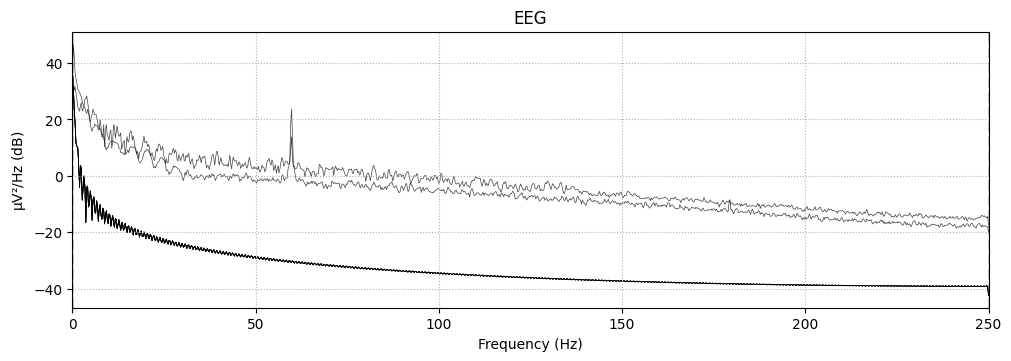

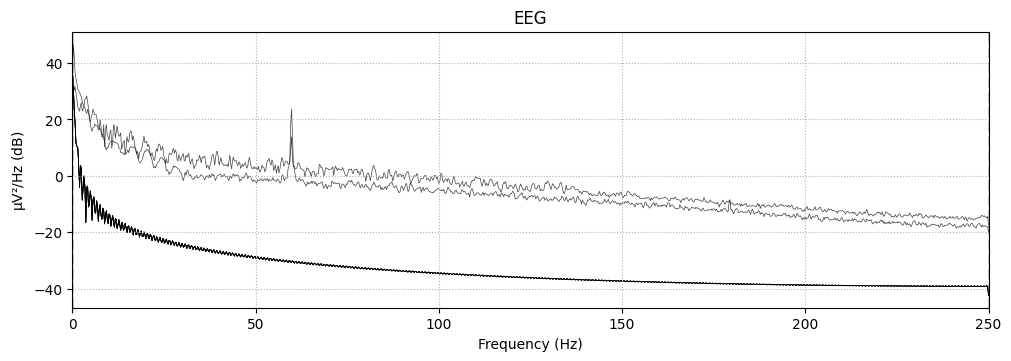

In [43]:
# Plot the Power Spectral Density
eeg_check[50].plot_psd(tmin=None, tmax=None, proj=False, color='black', area_mode='std', dB=True)


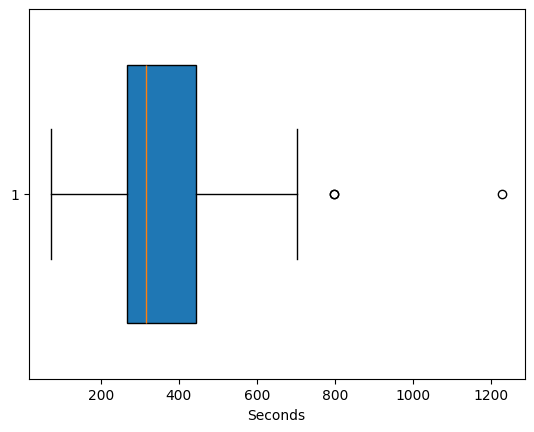

In [34]:
#looking at durations for clipping time
stats_dict = plt.boxplot(durations, vert=False, patch_artist=True, widths=0.7, showfliers=True)
plt.xlabel('Seconds')
plt.show()

In [ ]:
#apply a bandpass filter to the data -- will do this when loading
def bandpass_filter(data, low_freq, high_freq, sfreq):
    return mne.filter.filter_data(data, sfreq, l_freq=low_freq, h_freq=high_freq, verbose='ERROR')